# DS 504 eBay Auction Dataset Code

## Import libraries

In [2]:
import pandas as pd
import numpy as np

In [616]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import spearmanr
from xgboost import XGBRegressor
from xgboost import plot_tree
import graphviz

plt.style.use('seaborn-muted')

#rcParams['figure.figsize'] = (20,  10)

## Import training data, run some metrics/descriptions

In [492]:
training = pd.read_csv(r"data/TrainingSet.csv")
training.head()

,EbayID,QuantitySold,Price,PricePercent,StartingBidPercent,SellerName,SellerClosePercent,Category,PersonID,StartingBid,AvgPrice,EndDay,HitCount,AuctionAvgHitCount,ItemAuctionSellPercent,SellerSaleAvgPriceRatio,SellerAvg,SellerItemAvg,AuctionHitCountAvgRatio,BestOffer,ReturnsAccepted,IsHOF,ItemListedCount,AuctionCount,AuctionSaleCount,SellerAuctionCount,SellerAuctionSaleCount,AuctionMedianPrice
0,160983189073,1,27.25,1.4787,0.0537,petesandi,0.925926,73396,9174,0.99,18.4273,Tuesday,57,37,0,0.499142,2.06,56,29,1.540541,0,1,1,583,291,54,50,12.26
1,390549601720,1,43.00,1.4422,0.3350,graphn4fun,0.990566,27278,11046,9.99,29.8150,Sunday,34,84,1,0.358333,0.92,52,55,0.404762,0,0,0,120,43,106,105,24.45
2,200901284676,1,11.00,0.5969,0.5426,hondo19461946,0.422131,73396,9174,10.00,18.4273,Monday,12,37,0,0.499142,0.91,18,21,0.324324,0,1,1,583,291,244,103,12.26
3,271162670857,0,10.00,0.5426,0.5426,winemeyer45,0.245098,73396,9174,10.00,18.4273,Monday,10,37,0,0.499142,0.86,19,26,0.270270,0,0,1,583,291,102,25,12.26
4,310611578768,0,9.99,1.9159,1.9159,chucksmemorabilia,0.295359,73396,17956,9.99,5.2142,Monday,10,50,0,0.321168,0.59,33,53,0.200000,0,1,0,137,44,237,70,3.02


In [493]:
training.dtypes

EbayID                       int64
QuantitySold                 int64
Price                      float64
PricePercent               float64
StartingBidPercent         float64
SellerName                  object
SellerClosePercent         float64
Category                     int64
PersonID                     int64
StartingBid                float64
AvgPrice                   float64
EndDay                      object
HitCount                     int64
AuctionAvgHitCount           int64
ItemAuctionSellPercent       int64
SellerSaleAvgPriceRatio    float64
SellerAvg                  float64
SellerItemAvg                int64
AuctionHitCountAvgRatio      int64
BestOffer                  float64
ReturnsAccepted              int64
IsHOF                        int64
ItemListedCount              int64
AuctionCount                 int64
AuctionSaleCount             int64
SellerAuctionCount           int64
SellerAuctionSaleCount       int64
AuctionMedianPrice         float64
dtype: object

In [494]:
training.shape

(258588, 28)

In [495]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258588 entries, 0 to 258587
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   EbayID                   258588 non-null  int64  
 1   QuantitySold             258588 non-null  int64  
 2   Price                    258588 non-null  float64
 3   PricePercent             258588 non-null  float64
 4   StartingBidPercent       258588 non-null  float64
 5   SellerName               258588 non-null  object 
 6   SellerClosePercent       258588 non-null  float64
 7   Category                 258588 non-null  int64  
 8   PersonID                 258588 non-null  int64  
 9   StartingBid              258588 non-null  float64
 10  AvgPrice                 258588 non-null  float64
 11  EndDay                   258588 non-null  object 
 12  HitCount                 258588 non-null  int64  
 13  AuctionAvgHitCount       258588 non-null  int64  
 14  Item

In [496]:
# Are there any nulls in the dataset?
training.isnull().values.any()

False

In [497]:
#Double check nulls
training.isna().any()

EbayID                     False
QuantitySold               False
Price                      False
PricePercent               False
StartingBidPercent         False
SellerName                 False
SellerClosePercent         False
Category                   False
PersonID                   False
StartingBid                False
AvgPrice                   False
EndDay                     False
HitCount                   False
AuctionAvgHitCount         False
ItemAuctionSellPercent     False
SellerSaleAvgPriceRatio    False
SellerAvg                  False
SellerItemAvg              False
AuctionHitCountAvgRatio    False
BestOffer                  False
ReturnsAccepted            False
IsHOF                      False
ItemListedCount            False
AuctionCount               False
AuctionSaleCount           False
SellerAuctionCount         False
SellerAuctionSaleCount     False
AuctionMedianPrice         False
dtype: bool

In [498]:
#Unique records to understand data granularity. Compare to .shape
training.EbayID.nunique()

258588

In [499]:
#How many unique sellers?
training.SellerName.nunique()

11066

In [500]:
#Understand the data more
pd.set_option('display.max_columns', None)
training.describe().round(2)

,EbayID,QuantitySold,Price,PricePercent,StartingBidPercent,SellerClosePercent,Category,PersonID,StartingBid,AvgPrice,HitCount,AuctionAvgHitCount,ItemAuctionSellPercent,SellerSaleAvgPriceRatio,SellerAvg,SellerItemAvg,AuctionHitCountAvgRatio,BestOffer,ReturnsAccepted,IsHOF,ItemListedCount,AuctionCount,AuctionSaleCount,SellerAuctionCount,SellerAuctionSaleCount,AuctionMedianPrice
count,2.585880e+05,258588.00,258588.00,258588.00,258588.00,258588.00,258588.00,258588.00,258588.00,258588.00,258588.00,258588.00,258588.00,258588.00,258588.00,258588.00,258588.00,258588.00,258588.0,258588.00,258588.0,258588.00,258588.00,258588.00,258588.00,258588.00
mean,2.551335e+11,0.31,28.96,1.48,1.35,0.30,45689.39,22702.56,22.55,29.45,13.12,59.30,0.14,0.27,0.92,34.30,35.02,0.27,0.0,0.68,0.2,251.03,79.77,1121.24,253.56,19.72
std,8.851869e+10,0.46,44.56,12.02,12.02,0.29,24188.49,17254.92,39.92,76.50,24.89,42.69,0.34,0.16,0.59,53.07,40.49,0.43,0.0,0.47,0.4,342.17,130.65,1837.13,541.26,33.05
min,1.110137e+11,0.00,0.01,0.00,0.00,0.00,53.00,32.00,0.01,0.01,-1.00,1.00,0.00,0.01,0.00,0.00,0.00,-0.33,0.0,0.00,0.0,1.00,1.00,1.00,1.00,0.01
25%,1.710132e+11,0.00,3.29,0.53,0.34,0.06,27265.00,9842.00,1.99,4.12,2.00,34.00,0.00,0.15,0.57,6.00,9.00,0.05,0.0,0.00,0.0,41.00,7.00,88.00,11.00,2.25
50%,2.611893e+11,0.00,9.99,0.92,0.79,0.18,27278.00,19700.00,9.95,13.33,5.00,51.00,0.00,0.25,0.84,18.00,23.00,0.11,0.0,1.00,0.0,114.00,24.00,336.00,48.00,9.50
75%,3.308921e+11,1.00,34.01,1.46,1.38,0.49,73396.00,29469.00,24.95,35.94,11.00,74.00,0.00,0.37,1.13,44.00,46.00,0.29,0.0,1.00,0.0,307.00,89.25,1156.00,184.00,22.50
max,4.004741e+11,1.00,299.99,1799.00,1799.00,1.00,101810.00,68984.00,299.99,12672.08,1161.00,1554.00,1.00,1.00,27.73,3259.00,1600.00,18.75,0.0,1.00,1.0,2213.00,842.00,28777.00,8465.00,2402.75


In [501]:
item_activity = training.EndDay.value_counts(normalize = True).reset_index().sort_values('index')
item_activity

,index,EndDay
6,Friday,0.087804
1,Monday,0.156276
2,Saturday,0.154957
0,Sunday,0.277557
4,Thursday,0.098361
3,Tuesday,0.127071
5,Wednesday,0.097974


In [502]:
training.BestOffer.unique()

array([1.54054054, 0.4047619 , 0.32432432, ..., 1.77419355, 1.07777778,
       1.6440678 ])

In [503]:
training = training.drop(['AuctionAvgHitCount', 'Category', 'PersonID', 'AvgPrice', 'PricePercent', 'StartingBidPercent', 'BestOffer', 'SellerAvg', 'SellerItemAvg', 'AuctionHitCountAvgRatio', 'ItemListedCount', 'ReturnsAccepted'], axis=1)
training.columns

Index(['EbayID', 'QuantitySold', 'Price', 'SellerName', 'SellerClosePercent',
       'StartingBid', 'EndDay', 'HitCount', 'ItemAuctionSellPercent',
       'SellerSaleAvgPriceRatio', 'IsHOF', 'AuctionCount', 'AuctionSaleCount',
       'SellerAuctionCount', 'SellerAuctionSaleCount', 'AuctionMedianPrice'],
      dtype='object')

In [504]:
training.head()

,EbayID,QuantitySold,Price,SellerName,SellerClosePercent,StartingBid,EndDay,HitCount,ItemAuctionSellPercent,SellerSaleAvgPriceRatio,IsHOF,AuctionCount,AuctionSaleCount,SellerAuctionCount,SellerAuctionSaleCount,AuctionMedianPrice
0,160983189073,1,27.25,petesandi,0.925926,0.99,Tuesday,57,0,0.499142,1,583,291,54,50,12.26
1,390549601720,1,43.00,graphn4fun,0.990566,9.99,Sunday,34,1,0.358333,0,120,43,106,105,24.45
2,200901284676,1,11.00,hondo19461946,0.422131,10.00,Monday,12,0,0.499142,1,583,291,244,103,12.26
3,271162670857,0,10.00,winemeyer45,0.245098,10.00,Monday,10,0,0.499142,0,583,291,102,25,12.26
4,310611578768,0,9.99,chucksmemorabilia,0.295359,9.99,Monday,10,0,0.321168,1,137,44,237,70,3.02


## Import test dataset

In [435]:
test = pd.read_csv(r"data/TestSet.csv")
test.head()

,EbayID,QuantitySold,Price,PricePercent,StartingBidPercent,SellerName,SellerClosePercent,Category,PersonID,StartingBid,AvgPrice,EndDay,HitCount,AuctionAvgHitCount,ItemAuctionSellPercent,SellerSaleAvgPriceRatio,SellerAvg,SellerItemAvg,AuctionHitCountAvgRatio,BestOffer,ReturnsAccepted,IsHOF,ItemListedCount,AuctionCount,AuctionSaleCount,SellerAuctionCount,SellerAuctionSaleCount,AuctionMedianPrice
0,400476160084,0,0.99,0.5892,0.5892,harryjean0,0.128269,73409,8215,0.99,1.6800,Sunday,5,78,0,0.088608,0.42,3,6,0.064103,0,1,0,79,7,2791,358,0.99
1,350785007664,0,119.00,1.1427,1.1427,rrsports23,0.116667,27260,34,119.00,104.1330,Monday,6,77,1,0.458494,1.67,50,25,0.077922,0,1,1,1819,834,60,7,77.00
2,380629932508,1,1.75,1.0416,0.4464,mojo640,0.531599,73409,8215,0.75,1.6800,Thursday,8,78,0,0.088608,0.30,2,7,0.102564,0,0,0,79,7,269,143,0.99
3,300896813674,1,66.00,0.6338,0.0000,mintsignatures,0.971014,27260,34,0.01,104.1330,Saturday,116,77,0,0.458494,0.80,49,61,1.506494,0,1,1,1819,834,138,134,77.00
4,200918931232,0,9.99,0.5197,0.5197,realdealsignatures,0.187117,27285,28504,9.99,19.2203,Thursday,2,55,0,0.148515,0.28,2,8,0.036364,0,1,0,202,30,326,61,11.00


In [436]:
len(test)

37460

In [437]:
#drop columns that will not be useful for the model
test = test.drop(['AuctionAvgHitCount', 'Category', 'PersonID', 'AvgPrice', 'PricePercent', 'StartingBidPercent', 'BestOffer', 'SellerAvg', 'SellerItemAvg', 'AuctionHitCountAvgRatio', 'ItemListedCount', 'ReturnsAccepted'], axis=1)
test.columns

Index(['EbayID', 'QuantitySold', 'Price', 'SellerName', 'SellerClosePercent',
       'StartingBid', 'EndDay', 'HitCount', 'ItemAuctionSellPercent',
       'SellerSaleAvgPriceRatio', 'IsHOF', 'AuctionCount', 'AuctionSaleCount',
       'SellerAuctionCount', 'SellerAuctionSaleCount', 'AuctionMedianPrice'],
      dtype='object')

In [476]:
#are there any nulls in the testing data?
test.isnull().values.any()

False

In [477]:
test.describe().round(2)

,EbayID,QuantitySold,Price,SellerClosePercent,StartingBid,HitCount,ItemAuctionSellPercent,SellerSaleAvgPriceRatio,IsHOF,AuctionCount,AuctionSaleCount,SellerAuctionCount,SellerAuctionSaleCount,AuctionMedianPrice
count,3.746000e+04,37460.00,37460.00,37460.00,37460.00,37460.00,37460.00,37460.00,37460.00,37460.00,37460.00,37460.00,37460.00,37460.00
mean,2.547109e+11,0.25,24.65,0.25,20.11,10.29,0.11,0.26,0.67,225.29,69.18,934.67,224.06,16.49
std,8.995851e+10,0.43,40.56,0.27,36.92,20.65,0.31,0.16,0.47,313.28,118.61,1500.69,527.07,28.11
min,1.110568e+11,0.00,0.01,0.00,0.01,-1.00,0.00,0.01,0.00,1.00,1.00,1.00,1.00,0.01
25%,1.710325e+11,0.00,2.99,0.06,1.69,2.00,0.00,0.14,0.00,39.00,6.00,106.00,9.00,1.75
50%,2.612080e+11,0.00,9.99,0.14,7.99,4.00,0.00,0.23,1.00,104.00,20.00,330.00,36.00,6.99
75%,3.309155e+11,1.00,27.00,0.36,19.99,8.00,0.00,0.35,1.00,268.00,75.00,1071.00,142.00,18.50
max,4.004815e+11,1.00,299.99,1.00,315.00,366.00,1.00,1.00,1.00,2213.00,842.00,15688.00,2977.00,530.00


## Prepare the data for linearity plots

In [478]:
#What columns do I have?
training.columns

Index(['EbayID', 'QuantitySold', 'Price', 'SellerName', 'SellerClosePercent',
       'StartingBid', 'EndDay', 'HitCount', 'ItemAuctionSellPercent',
       'SellerSaleAvgPriceRatio', 'IsHOF', 'AuctionCount', 'AuctionSaleCount',
       'SellerAuctionCount', 'SellerAuctionSaleCount', 'AuctionMedianPrice'],
      dtype='object')

In [430]:
#list of features I care about
features = ['QuantitySold', 'SellerClosePercent',
       'StartingBid', 'HitCount', 'ItemAuctionSellPercent',
       'SellerSaleAvgPriceRatio', 'IsHOF',
       'AuctionCount', 'AuctionSaleCount',
       'SellerAuctionCount', 'SellerAuctionSaleCount', 'AuctionMedianPrice']

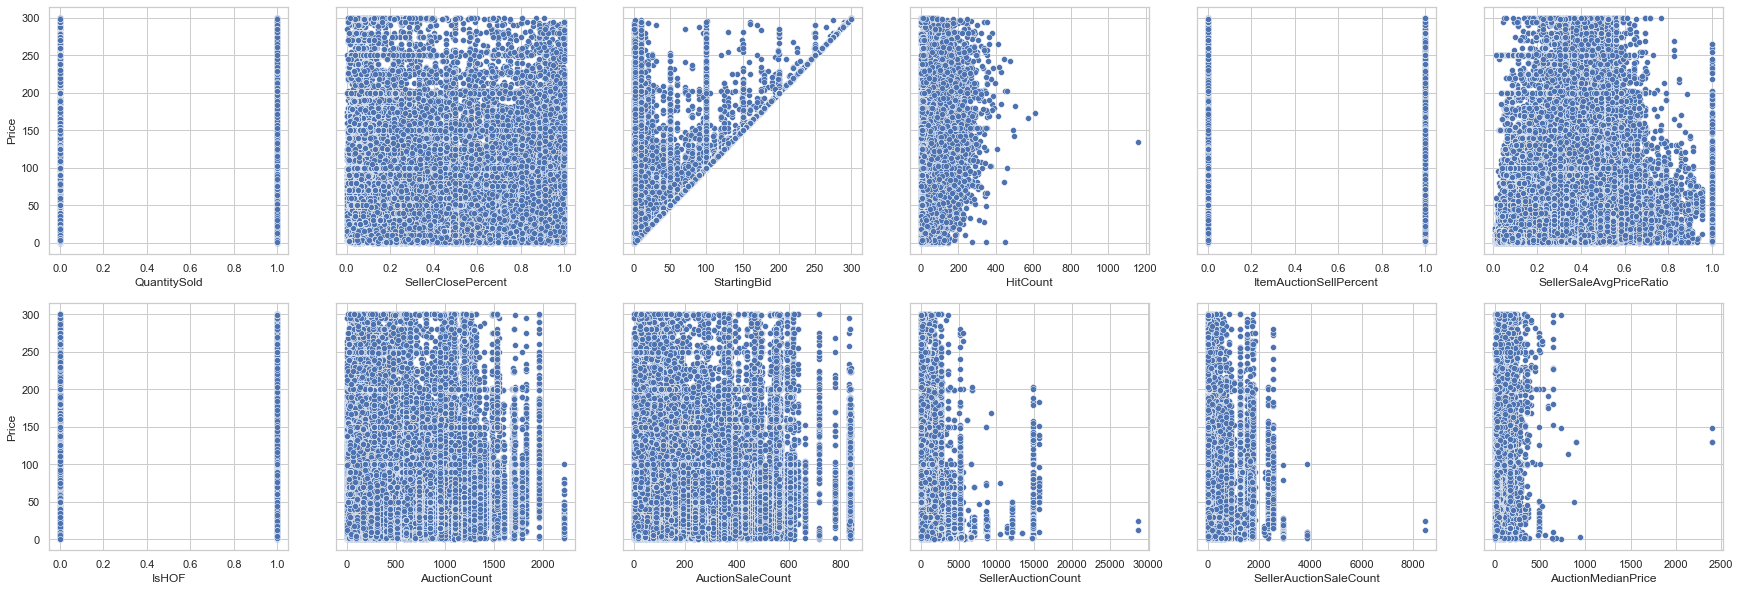

In [433]:
#scatter plot the features
fig, axes = plt.subplots(2, 6, figsize=(30, 10), sharey=True)

sns.scatterplot(ax=axes[0,0], data=training, x=training[features[0]], y='Price', palette='RdBu')
sns.scatterplot(ax=axes[0,1], data=training, x=training[features[1]], y='Price', palette='RdBu')
sns.scatterplot(ax=axes[0,2], data=training, x=training[features[2]], y='Price', palette='RdBu')
sns.scatterplot(ax=axes[0,3], data=training, x=training[features[3]], y='Price', palette='RdBu')
sns.scatterplot(ax=axes[0,4], data=training, x=training[features[4]], y='Price', palette='RdBu')
sns.scatterplot(ax=axes[0,5], data=training, x=training[features[5]], y='Price', palette='RdBu')

sns.scatterplot(ax=axes[1,0], data=training, x=training[features[6]], y='Price', palette='RdBu')
sns.scatterplot(ax=axes[1,1], data=training, x=training[features[7]], y='Price', palette='RdBu')
sns.scatterplot(ax=axes[1,2], data=training, x=training[features[8]], y='Price', palette='RdBu')
sns.scatterplot(ax=axes[1,3], data=training, x=training[features[9]], y='Price', palette='RdBu')
sns.scatterplot(ax=axes[1,4], data=training, x=training[features[10]], y='Price', palette='RdBu')
sns.scatterplot(ax=axes[1,5], data=training, x=training[features[11]], y='Price', palette='RdBu')

plt.show()

In [434]:
features

['QuantitySold',
 'SellerClosePercent',
 'StartingBid',
 'HitCount',
 'ItemAuctionSellPercent',
 'SellerSaleAvgPriceRatio',
 'IsHOF',
 'AuctionCount',
 'AuctionSaleCount',
 'SellerAuctionCount',
 'SellerAuctionSaleCount',
 'AuctionMedianPrice']

## Understand more about the training data patterns

In [440]:
training['EndDay'] = pd.Categorical(training['EndDay'],
                                   categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                   ordered=True)

In [442]:
rcParams['figure.figsize'] = (20,  10)

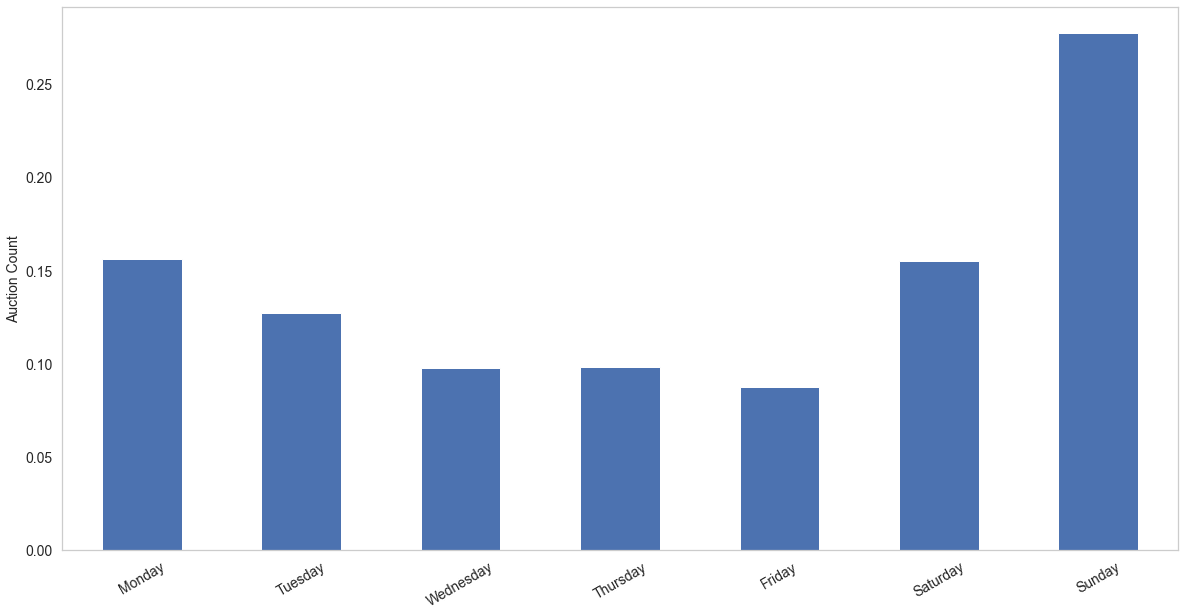

In [453]:
#how much activity per item type

training.EndDay.value_counts(normalize = True).sort_index().plot(kind="bar")
#plt.title("Day of the week auctions ended", fontsize = 20)
plt.xticks(rotation=30, fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Auction Count", fontsize = 14)
plt.grid(visible=None)
plt.show()

Text(0, 0.5, 'Final Price')

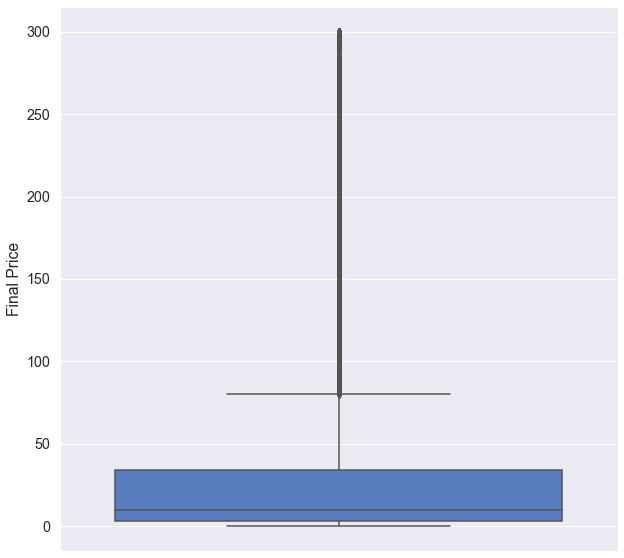

In [456]:
#box plot of the final price
sns.set_style("whitegrid")
rcParams['figure.figsize'] = (10,  10)
sns.set(font_scale=1.3)
sns.boxplot(y="Price", data=training, palette="muted")
#sns.color_palette("bright")
plt.xlabel('')
plt.ylabel('Final Price')

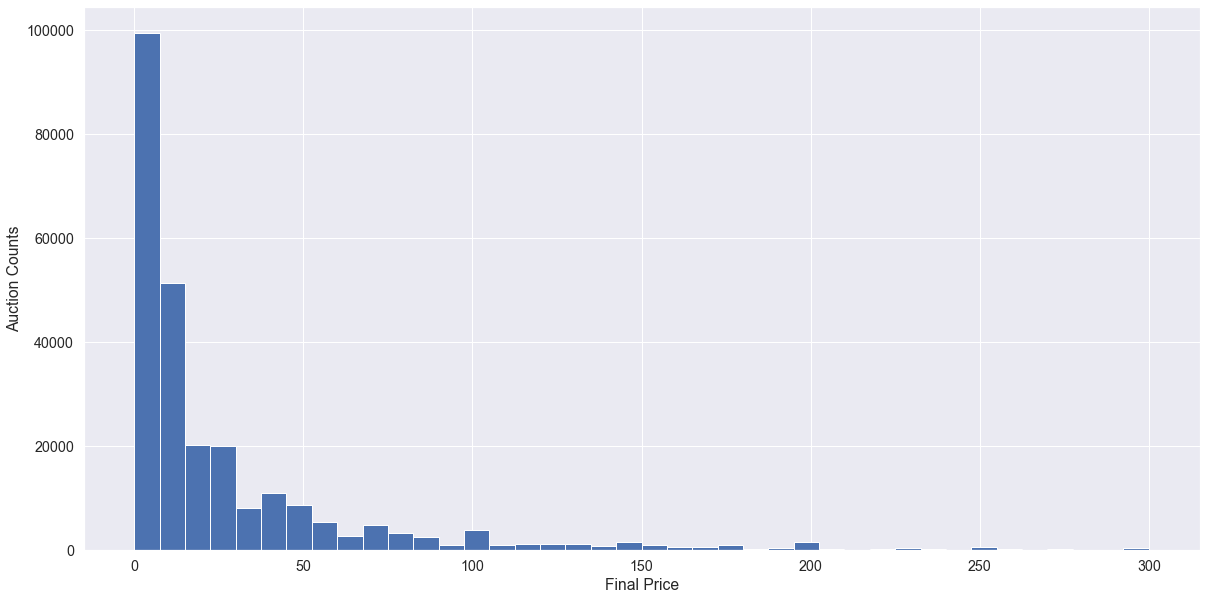

In [460]:
#seeing if there is variation in predicted variable Price to see if I need rmsle or rmse

rcParams['figure.figsize'] = (20,  10)
plt.hist(training['Price'], bins = 40)
plt.xlabel('Final Price')
plt.ylabel('Auction Counts')
plt.show() 

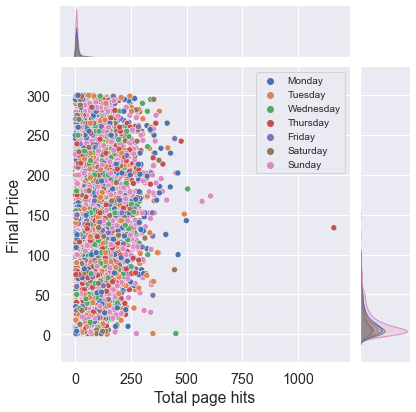

In [463]:
#understand if there are patterns in final price with hit count based on the days of the week

plot = sns.jointplot(x='HitCount', y="Price", data=training, hue='EndDay')
rcParams['figure.figsize'] = (20,  20)
#plot.ax_marg_y.set_ylim(0, 2000)
plot.set_axis_labels(xlabel='Total page hits', ylabel='Final Price')
plot.fig.get_axes()[0].legend(loc='upper right', fontsize = 10)

Text(0, 0.5, 'Opening bid amount')

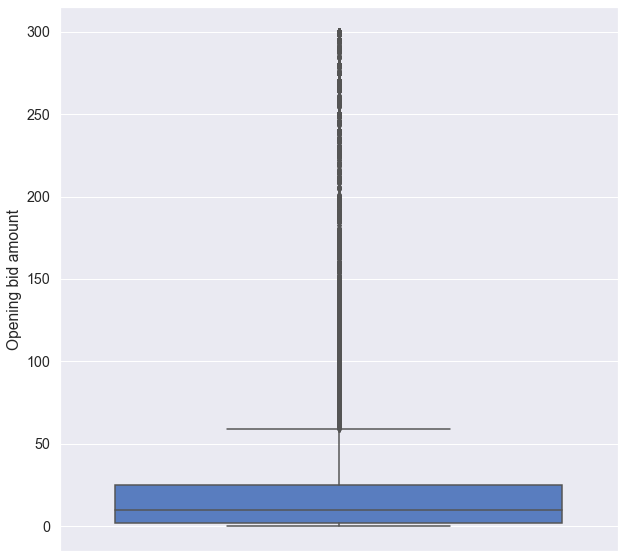

In [461]:
sns.set_style("whitegrid")
rcParams['figure.figsize'] = (10,  10)
sns.set(font_scale=1.3)
sns.boxplot(y="StartingBid", data=training, palette="muted")
#sns.color_palette("bright")
plt.xlabel('')
plt.ylabel('Opening bid amount')

In [465]:
#set up data for correlation plot

corr = training[['QuantitySold', 'Price', 'SellerClosePercent', 'StartingBid', \
            'HitCount', 'ItemAuctionSellPercent', 'SellerSaleAvgPriceRatio', 'IsHOF', \
           'AuctionCount', 'AuctionSaleCount', \
           'SellerAuctionCount', 'SellerAuctionSaleCount', 'AuctionMedianPrice']].corr()
corr

,QuantitySold,Price,SellerClosePercent,StartingBid,HitCount,ItemAuctionSellPercent,SellerSaleAvgPriceRatio,IsHOF,AuctionCount,AuctionSaleCount,SellerAuctionCount,SellerAuctionSaleCount,AuctionMedianPrice
QuantitySold,1.000000,0.061080,0.626917,-0.172144,0.499577,0.076827,0.359300,0.014467,0.106792,0.160403,-0.078832,0.236291,0.179222
Price,0.061080,1.000000,0.088385,0.844167,0.401708,0.209172,0.282112,-0.066227,0.317842,0.380123,-0.174107,-0.059713,0.677254
SellerClosePercent,0.626917,0.088385,1.000000,-0.163144,0.496199,0.113847,0.315243,0.014416,0.123390,0.170401,-0.150081,0.360049,0.200841
StartingBid,-0.172144,0.844167,-0.163144,1.000000,-0.016219,0.127113,0.163890,-0.076905,0.233173,0.262384,-0.157329,-0.139745,0.486580
HitCount,0.499577,0.401708,0.496199,-0.016219,1.000000,0.177309,0.325253,-0.023426,0.254168,0.333554,-0.122155,0.082106,0.494239
ItemAuctionSellPercent,0.076827,0.209172,0.113847,0.127113,0.177309,1.000000,0.056446,0.090936,0.098086,0.099924,0.157739,0.098836,0.142454
SellerSaleAvgPriceRatio,0.359300,0.282112,0.315243,0.163890,0.325253,0.056446,1.000000,-0.049513,0.204693,0.365768,-0.224988,0.014740,0.295325
IsHOF,0.014467,-0.066227,0.014416,-0.076905,-0.023426,0.090936,-0.049513,1.000000,-0.045866,-0.062638,0.241202,0.167446,-0.063850
AuctionCount,0.106792,0.317842,0.123390,0.233173,0.254168,0.098086,0.204693,-0.045866,1.000000,0.936193,-0.129286,-0.023677,0.316684
AuctionSaleCount,0.160403,0.380123,0.170401,0.262384,0.333554,0.099924,0.365768,-0.062638,0.936193,1.000000,-0.154018,-0.028124,0.390894


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 [Text(0, 0.5, 'QuantitySold'),
  Text(0, 1.5, 'Price'),
  Text(0, 2.5, 'SellerClosePercent'),
  Text(0, 3.5, 'StartingBid'),
  Text(0, 4.5, 'HitCount'),
  Text(0, 5.5, 'ItemAuctionSellPercent'),
  Text(0, 6.5, 'SellerSaleAvgPriceRatio'),
  Text(0, 7.5, 'IsHOF'),
  Text(0, 8.5, 'AuctionCount'),
  Text(0, 9.5, 'AuctionSaleCount'),
  Text(0, 10.5, 'SellerAuctionCount'),
  Text(0, 11.5, 'SellerAuctionSaleCount'),
  Text(0, 12.5, 'AuctionMedianPrice')])

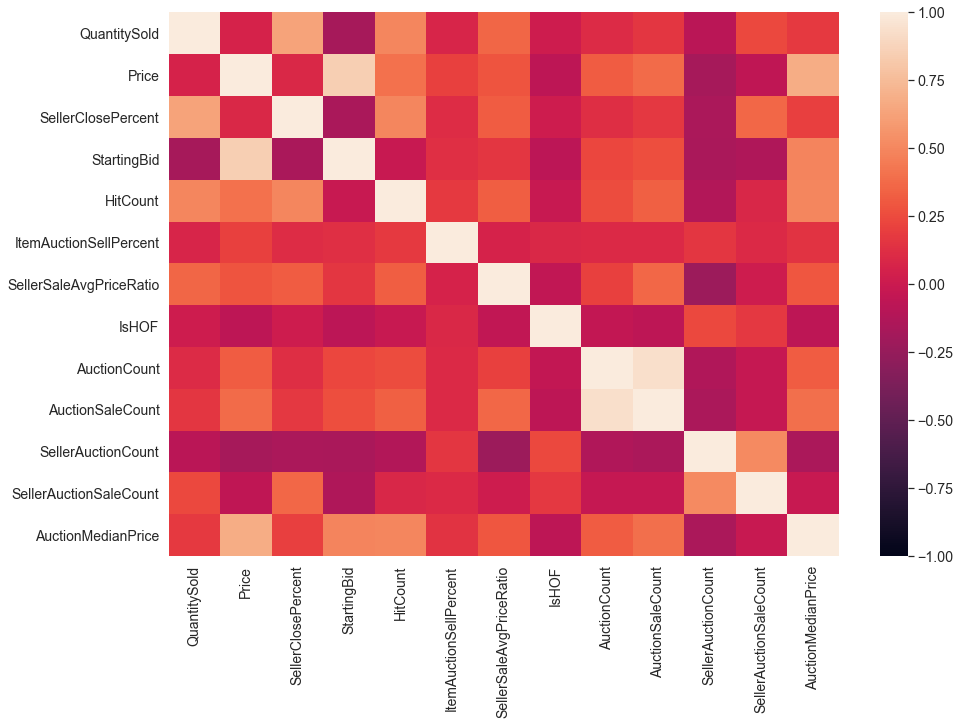

In [471]:
#plot correlation

rcParams['figure.figsize'] = (15,  10)
sns.heatmap(corr, 
        xticklabels=['QuantitySold', 'Price', 'SellerClosePercent', 'StartingBid', \
            'HitCount', 'ItemAuctionSellPercent', 'SellerSaleAvgPriceRatio', 'IsHOF', \
               'AuctionCount', 'AuctionSaleCount', \
               'SellerAuctionCount', 'SellerAuctionSaleCount', 'AuctionMedianPrice'],
        yticklabels=['QuantitySold', 'Price', 'SellerClosePercent', 'StartingBid', \
            'HitCount', 'ItemAuctionSellPercent', 'SellerSaleAvgPriceRatio', 'IsHOF', \
               'AuctionCount', 'AuctionSaleCount', \
               'SellerAuctionCount', 'SellerAuctionSaleCount', 'AuctionMedianPrice'],
                vmin=-1, vmax=1)
plt.ylabel('')
plt.xticks(fontsize = 14)#, rotation=30)
plt.yticks(fontsize = 14)

Text(0, 0.5, 'Number of page hits')

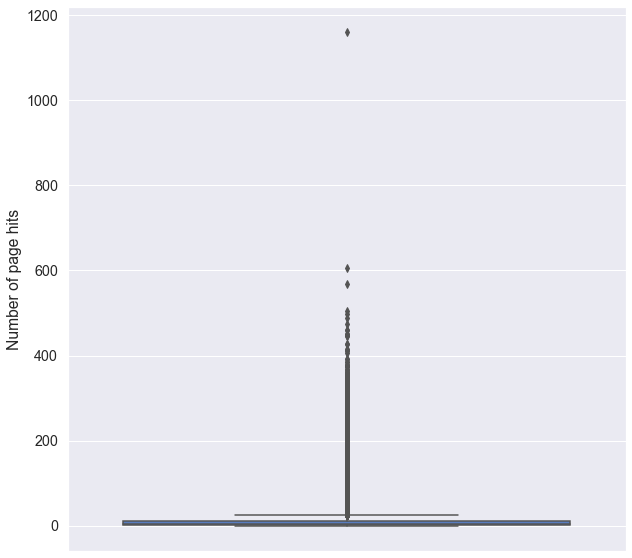

In [473]:
#histogram of a few features

rcParams['figure.figsize'] = (10,  10)
sns.set_style("whitegrid")

sns.set(font_scale=1.3)
sns.boxplot(y='HitCount', data=training, palette="muted")
#sns.color_palette("bright")
plt.xlabel('')
plt.ylabel('Number of page hits')

Text(0, 0.5, 'Auction Median Price')

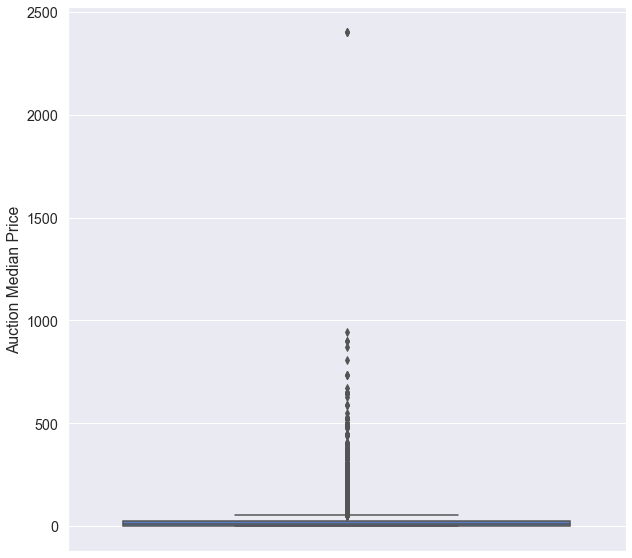

In [474]:
#histogram of a few features

rcParams['figure.figsize'] = (10,  10)
sns.set_style("whitegrid")

sns.set(font_scale=1.3)
sns.boxplot(y='AuctionMedianPrice', data=training, palette="muted")
#sns.color_palette("bright")
plt.xlabel('')
plt.ylabel('Auction Median Price')

# Part 2 - Data analysis

In [479]:
import xgboost as xg
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder

In [480]:
training.head()

,EbayID,QuantitySold,Price,SellerName,SellerClosePercent,StartingBid,EndDay,HitCount,ItemAuctionSellPercent,SellerSaleAvgPriceRatio,IsHOF,AuctionCount,AuctionSaleCount,SellerAuctionCount,SellerAuctionSaleCount,AuctionMedianPrice
0,160983189073,1,27.25,petesandi,0.925926,0.99,Tuesday,57,0,0.499142,1,583,291,54,50,12.26
1,390549601720,1,43.00,graphn4fun,0.990566,9.99,Sunday,34,1,0.358333,0,120,43,106,105,24.45
2,200901284676,1,11.00,hondo19461946,0.422131,10.00,Monday,12,0,0.499142,1,583,291,244,103,12.26
3,271162670857,0,10.00,winemeyer45,0.245098,10.00,Monday,10,0,0.499142,0,583,291,102,25,12.26
4,310611578768,0,9.99,chucksmemorabilia,0.295359,9.99,Monday,10,0,0.321168,1,137,44,237,70,3.02


In [481]:
print(xg.__version__)

1.5.0


In [522]:
#copy data so I'm creating a new set of data that I can easily modify if needed, without having to load the data again
train = training.copy()
test1 = test.copy()

In [523]:
#create one hot encoding for the end day categorical variable
one_hot = pd.get_dummies(train['EndDay'])

#drop EndDay from the dataset as it is no longer needed
train = train.drop('EndDay',axis = 1)

#join the one hot encoding to the original dataset
train = train.join(one_hot)

In [524]:
train.head()

,EbayID,QuantitySold,Price,SellerName,SellerClosePercent,StartingBid,HitCount,ItemAuctionSellPercent,SellerSaleAvgPriceRatio,IsHOF,AuctionCount,AuctionSaleCount,SellerAuctionCount,SellerAuctionSaleCount,AuctionMedianPrice,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,160983189073,1,27.25,petesandi,0.925926,0.99,57,0,0.499142,1,583,291,54,50,12.26,0,0,0,0,0,1,0
1,390549601720,1,43.00,graphn4fun,0.990566,9.99,34,1,0.358333,0,120,43,106,105,24.45,0,0,0,1,0,0,0
2,200901284676,1,11.00,hondo19461946,0.422131,10.00,12,0,0.499142,1,583,291,244,103,12.26,0,1,0,0,0,0,0
3,271162670857,0,10.00,winemeyer45,0.245098,10.00,10,0,0.499142,0,583,291,102,25,12.26,0,1,0,0,0,0,0
4,310611578768,0,9.99,chucksmemorabilia,0.295359,9.99,10,0,0.321168,1,137,44,237,70,3.02,0,1,0,0,0,0,0


In [525]:
#do the same thing to testing data
one_hot = pd.get_dummies(test1['EndDay'])

test1 = test1.drop('EndDay',axis = 1)

test1 = test1.join(one_hot)

In [526]:
#X1 and y1 are the training datasets (features and target respectively)
#Xt and yt are the testing datasets (features and target respectively)
X1, y1 = train.loc[:, ~train.columns.isin(['Price', 'EbayID', 'SellerName'])], train.loc[:, train.columns=='Price']
Xt, yt = test1.loc[:, ~test1.columns.isin(['Price', 'EbayID', 'SellerName'])], test1.loc[:, test1.columns=='Price']

In [533]:
#train model without default parameters
model = XGBRegressor()
model.fit(
    X1, 
    y1, 
    eval_metric="rmse", 
    eval_set=[(X1, y1), (Xt, yt)], 
    verbose=True, 
    early_stopping_rounds = 20)

[0]	validation_0-rmse:38.11299	validation_1-rmse:33.96389
[1]	validation_0-rmse:28.08838	validation_1-rmse:24.95238
[2]	validation_0-rmse:21.38125	validation_1-rmse:18.89411
[3]	validation_0-rmse:17.12234	validation_1-rmse:15.10011
[4]	validation_0-rmse:14.45630	validation_1-rmse:12.71555
[5]	validation_0-rmse:12.89378	validation_1-rmse:11.34494
[6]	validation_0-rmse:12.00807	validation_1-rmse:10.60906
[7]	validation_0-rmse:11.49312	validation_1-rmse:10.20428
[8]	validation_0-rmse:11.18001	validation_1-rmse:9.98092
[9]	validation_0-rmse:10.99211	validation_1-rmse:9.82894
[10]	validation_0-rmse:10.86747	validation_1-rmse:9.75836
[11]	validation_0-rmse:10.75482	validation_1-rmse:9.69858
[12]	validation_0-rmse:10.67384	validation_1-rmse:9.66196
[13]	validation_0-rmse:10.60144	validation_1-rmse:9.66557
[14]	validation_0-rmse:10.51816	validation_1-rmse:9.64795
[15]	validation_0-rmse:10.42335	validation_1-rmse:9.59231
[16]	validation_0-rmse:10.33372	validation_1-rmse:9.56713
[17]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [534]:
#view number of best trees
model.best_ntree_limit

84

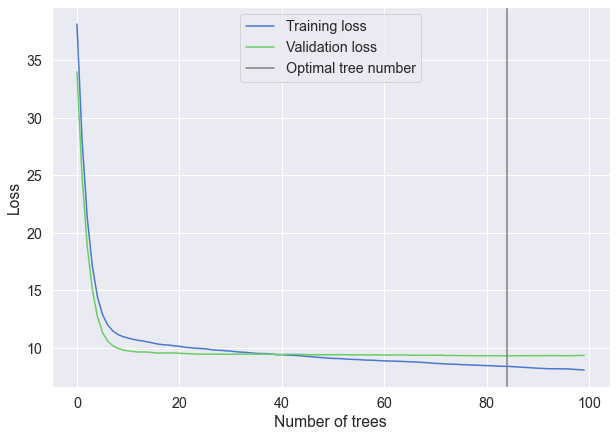

In [529]:
#view plot of the optimal tree and the training vs. val loss
results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(model.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

<AxesSubplot:>

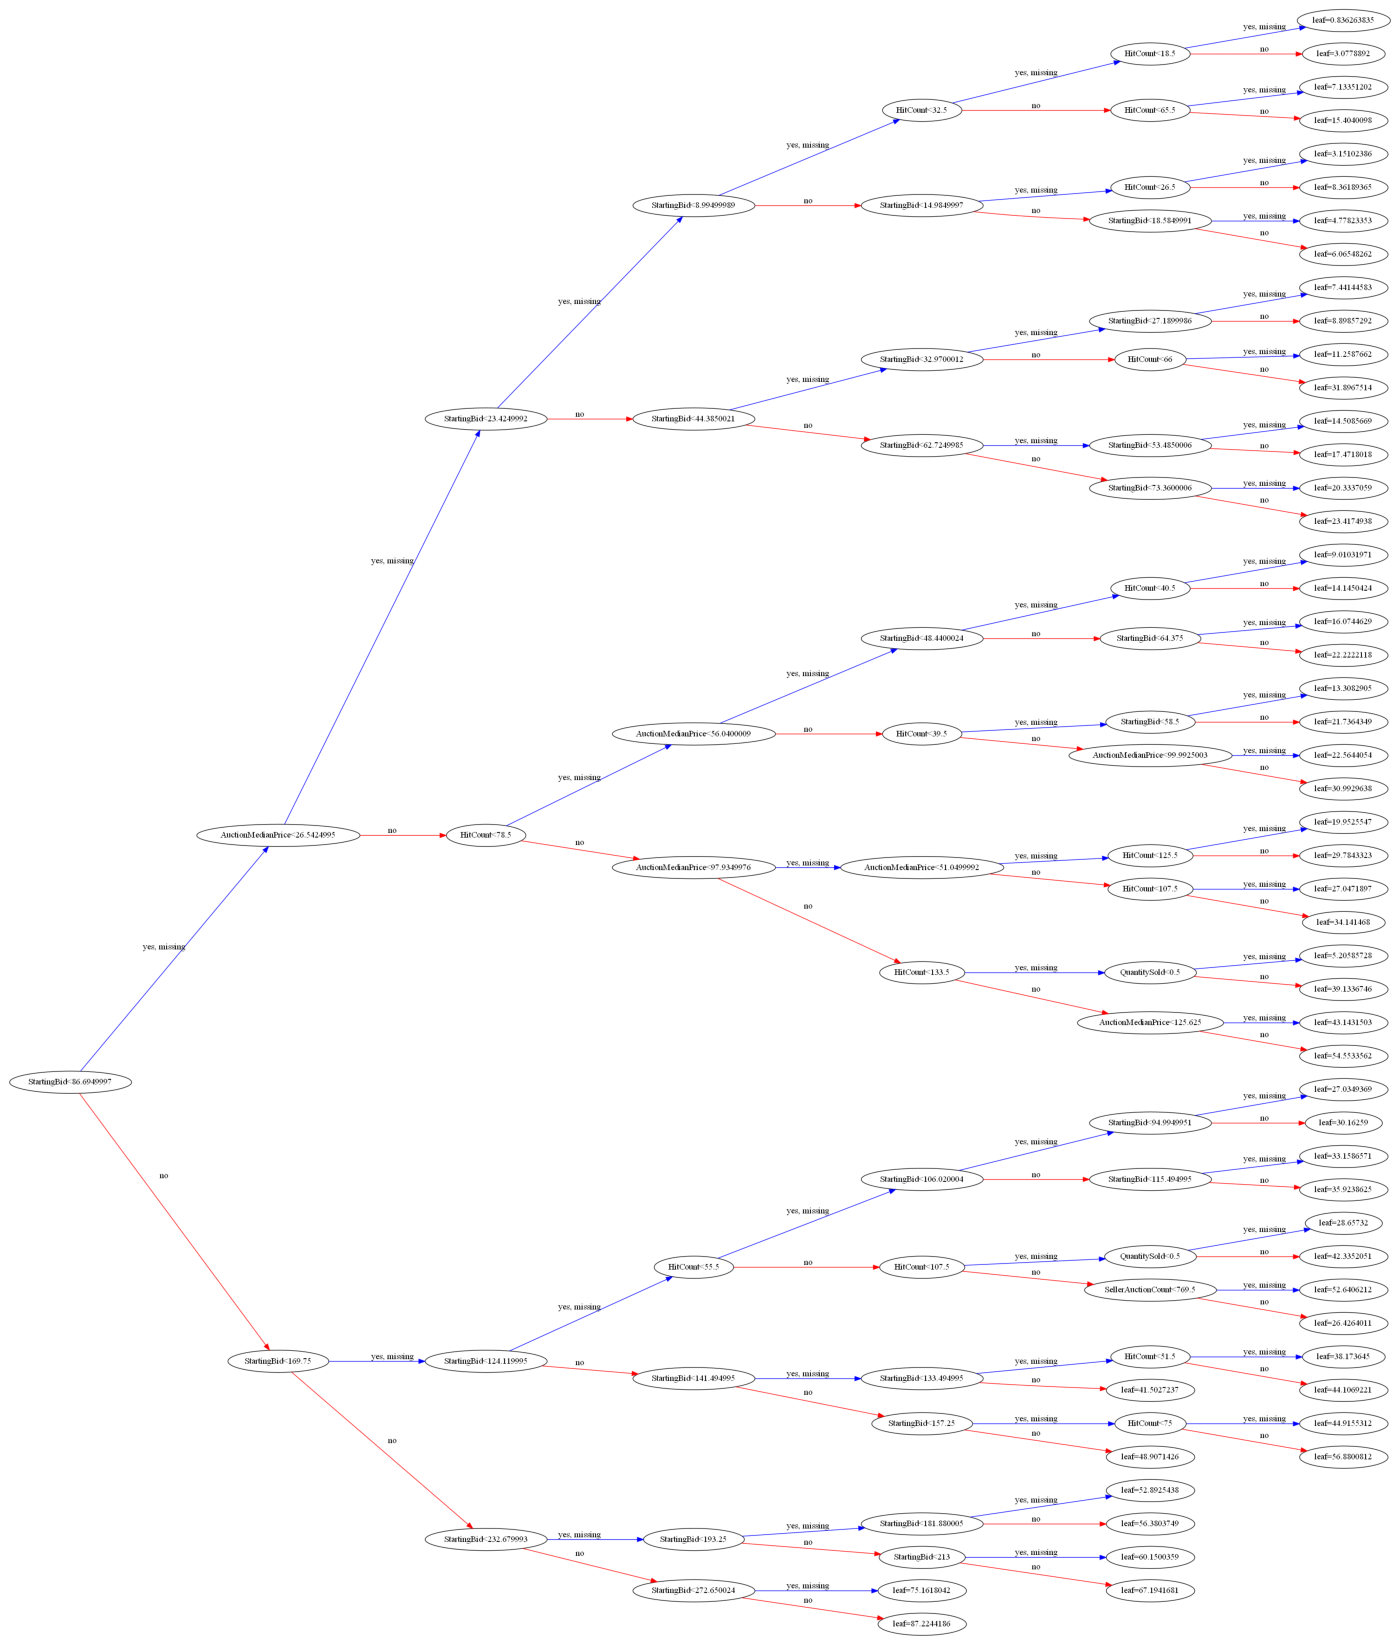

In [530]:
#view tree
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(model, num_trees=0, rankdir='LR', ax = ax)

In [538]:
score_baseline = model.score(X1, y1)
score_baseline

0.9642705360575201

In [536]:
model1 = XGBRegressor(
    max_depth=7,
    n_estimators=1200,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.015,
    seed=9)
#learning_rate=0.100000001

In [537]:

model1.fit(
    X1, 
    y1, 
    eval_metric="rmse", 
    eval_set=[(X1, y1), (Xt, yt)], 
    verbose=True, 
    early_stopping_rounds = 20)

[0]	validation_0-rmse:52.28639	validation_1-rmse:46.68817
[1]	validation_0-rmse:51.71229	validation_1-rmse:46.18114
[2]	validation_0-rmse:50.97968	validation_1-rmse:45.52369
[3]	validation_0-rmse:50.26686	validation_1-rmse:44.88182
[4]	validation_0-rmse:49.56598	validation_1-rmse:44.25075
[5]	validation_0-rmse:48.87613	validation_1-rmse:43.62867
[6]	validation_0-rmse:48.19615	validation_1-rmse:43.01384
[7]	validation_0-rmse:47.81370	validation_1-rmse:42.68221
[8]	validation_0-rmse:47.14956	validation_1-rmse:42.08141
[9]	validation_0-rmse:46.49651	validation_1-rmse:41.49150
[10]	validation_0-rmse:45.84661	validation_1-rmse:40.90792
[11]	validation_0-rmse:45.35654	validation_1-rmse:40.47492
[12]	validation_0-rmse:44.73143	validation_1-rmse:39.90986
[13]	validation_0-rmse:44.11644	validation_1-rmse:39.35358
[14]	validation_0-rmse:43.51117	validation_1-rmse:38.80618
[15]	validation_0-rmse:42.91420	validation_1-rmse:38.26850
[16]	validation_0-rmse:42.32015	validation_1-rmse:37.73574
[17]	va

[139]	validation_0-rmse:13.08100	validation_1-rmse:11.65610
[140]	validation_0-rmse:13.01642	validation_1-rmse:11.59988
[141]	validation_0-rmse:12.95380	validation_1-rmse:11.54636
[142]	validation_0-rmse:12.89176	validation_1-rmse:11.49357
[143]	validation_0-rmse:12.83101	validation_1-rmse:11.44065
[144]	validation_0-rmse:12.79305	validation_1-rmse:11.41378
[145]	validation_0-rmse:12.76393	validation_1-rmse:11.39081
[146]	validation_0-rmse:12.70639	validation_1-rmse:11.34148
[147]	validation_0-rmse:12.65079	validation_1-rmse:11.29304
[148]	validation_0-rmse:12.59650	validation_1-rmse:11.24585
[149]	validation_0-rmse:12.56211	validation_1-rmse:11.22176
[150]	validation_0-rmse:12.52974	validation_1-rmse:11.19758
[151]	validation_0-rmse:12.50802	validation_1-rmse:11.18089
[152]	validation_0-rmse:12.45866	validation_1-rmse:11.13873
[153]	validation_0-rmse:12.41104	validation_1-rmse:11.09727
[154]	validation_0-rmse:12.36142	validation_1-rmse:11.05476
[155]	validation_0-rmse:12.31287	validat

[277]	validation_0-rmse:10.29816	validation_1-rmse:9.53493
[278]	validation_0-rmse:10.29242	validation_1-rmse:9.53148
[279]	validation_0-rmse:10.28588	validation_1-rmse:9.52834
[280]	validation_0-rmse:10.28163	validation_1-rmse:9.52643
[281]	validation_0-rmse:10.27574	validation_1-rmse:9.52207
[282]	validation_0-rmse:10.26944	validation_1-rmse:9.51831
[283]	validation_0-rmse:10.26469	validation_1-rmse:9.51746
[284]	validation_0-rmse:10.25906	validation_1-rmse:9.51384
[285]	validation_0-rmse:10.25365	validation_1-rmse:9.50999
[286]	validation_0-rmse:10.24832	validation_1-rmse:9.50771
[287]	validation_0-rmse:10.24333	validation_1-rmse:9.50478
[288]	validation_0-rmse:10.23709	validation_1-rmse:9.50173
[289]	validation_0-rmse:10.23200	validation_1-rmse:9.49875
[290]	validation_0-rmse:10.22663	validation_1-rmse:9.49637
[291]	validation_0-rmse:10.22170	validation_1-rmse:9.49524
[292]	validation_0-rmse:10.21558	validation_1-rmse:9.49389
[293]	validation_0-rmse:10.21154	validation_1-rmse:9.491

[418]	validation_0-rmse:9.76483	validation_1-rmse:9.32282
[419]	validation_0-rmse:9.75950	validation_1-rmse:9.32181
[420]	validation_0-rmse:9.75605	validation_1-rmse:9.32025
[421]	validation_0-rmse:9.75212	validation_1-rmse:9.31851
[422]	validation_0-rmse:9.74894	validation_1-rmse:9.31705
[423]	validation_0-rmse:9.74592	validation_1-rmse:9.31678
[424]	validation_0-rmse:9.74382	validation_1-rmse:9.31610
[425]	validation_0-rmse:9.73959	validation_1-rmse:9.31482
[426]	validation_0-rmse:9.73700	validation_1-rmse:9.31471
[427]	validation_0-rmse:9.73539	validation_1-rmse:9.31425
[428]	validation_0-rmse:9.73106	validation_1-rmse:9.31367
[429]	validation_0-rmse:9.72875	validation_1-rmse:9.31333
[430]	validation_0-rmse:9.72630	validation_1-rmse:9.31265
[431]	validation_0-rmse:9.72300	validation_1-rmse:9.31259
[432]	validation_0-rmse:9.71909	validation_1-rmse:9.31145
[433]	validation_0-rmse:9.71643	validation_1-rmse:9.30925
[434]	validation_0-rmse:9.71386	validation_1-rmse:9.30862
[435]	validati

[560]	validation_0-rmse:9.36163	validation_1-rmse:9.25130
[561]	validation_0-rmse:9.35986	validation_1-rmse:9.25082
[562]	validation_0-rmse:9.35718	validation_1-rmse:9.24922
[563]	validation_0-rmse:9.35521	validation_1-rmse:9.24828
[564]	validation_0-rmse:9.35179	validation_1-rmse:9.24827
[565]	validation_0-rmse:9.34982	validation_1-rmse:9.24871
[566]	validation_0-rmse:9.34719	validation_1-rmse:9.24771
[567]	validation_0-rmse:9.34601	validation_1-rmse:9.24833
[568]	validation_0-rmse:9.34360	validation_1-rmse:9.24816
[569]	validation_0-rmse:9.34137	validation_1-rmse:9.24802
[570]	validation_0-rmse:9.33788	validation_1-rmse:9.24765
[571]	validation_0-rmse:9.33538	validation_1-rmse:9.24740
[572]	validation_0-rmse:9.33302	validation_1-rmse:9.24762
[573]	validation_0-rmse:9.32996	validation_1-rmse:9.24831
[574]	validation_0-rmse:9.32636	validation_1-rmse:9.24723
[575]	validation_0-rmse:9.32500	validation_1-rmse:9.24750
[576]	validation_0-rmse:9.32278	validation_1-rmse:9.24747
[577]	validati

[702]	validation_0-rmse:9.02625	validation_1-rmse:9.20888
[703]	validation_0-rmse:9.02369	validation_1-rmse:9.20804
[704]	validation_0-rmse:9.01923	validation_1-rmse:9.20666
[705]	validation_0-rmse:9.01772	validation_1-rmse:9.20659
[706]	validation_0-rmse:9.01478	validation_1-rmse:9.20587
[707]	validation_0-rmse:9.01386	validation_1-rmse:9.20565
[708]	validation_0-rmse:9.01176	validation_1-rmse:9.20554
[709]	validation_0-rmse:9.00992	validation_1-rmse:9.20518
[710]	validation_0-rmse:9.00794	validation_1-rmse:9.20383
[711]	validation_0-rmse:9.00715	validation_1-rmse:9.20248
[712]	validation_0-rmse:9.00471	validation_1-rmse:9.20195
[713]	validation_0-rmse:9.00363	validation_1-rmse:9.20193
[714]	validation_0-rmse:9.00032	validation_1-rmse:9.20165
[715]	validation_0-rmse:8.99856	validation_1-rmse:9.20098
[716]	validation_0-rmse:8.99591	validation_1-rmse:9.20131
[717]	validation_0-rmse:8.99393	validation_1-rmse:9.20193
[718]	validation_0-rmse:8.99291	validation_1-rmse:9.20174
[719]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.015, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0149999997,
             max_delta_step=0, max_depth=7, min_child_weight=0.5, missing=nan,
             monotone_constraints='()', n_estimators=1200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=9, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=9, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [539]:
score_best = model1.score(X1, y1)
score_best

0.9595033664654606

In [541]:
model1.best_ntree_limit

730

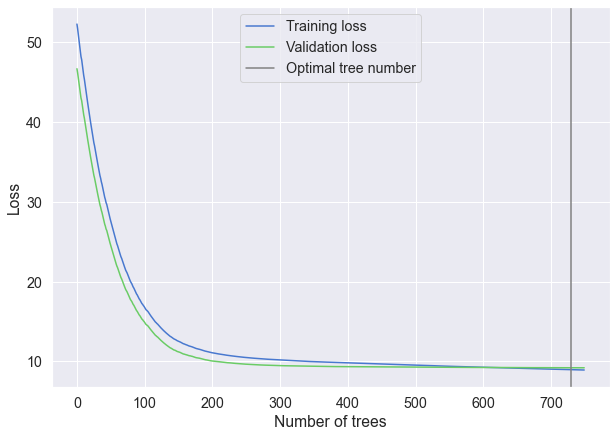

In [542]:
#view plot of the optimal tree and the training vs. val loss
results = model1.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(model1.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

<AxesSubplot:>

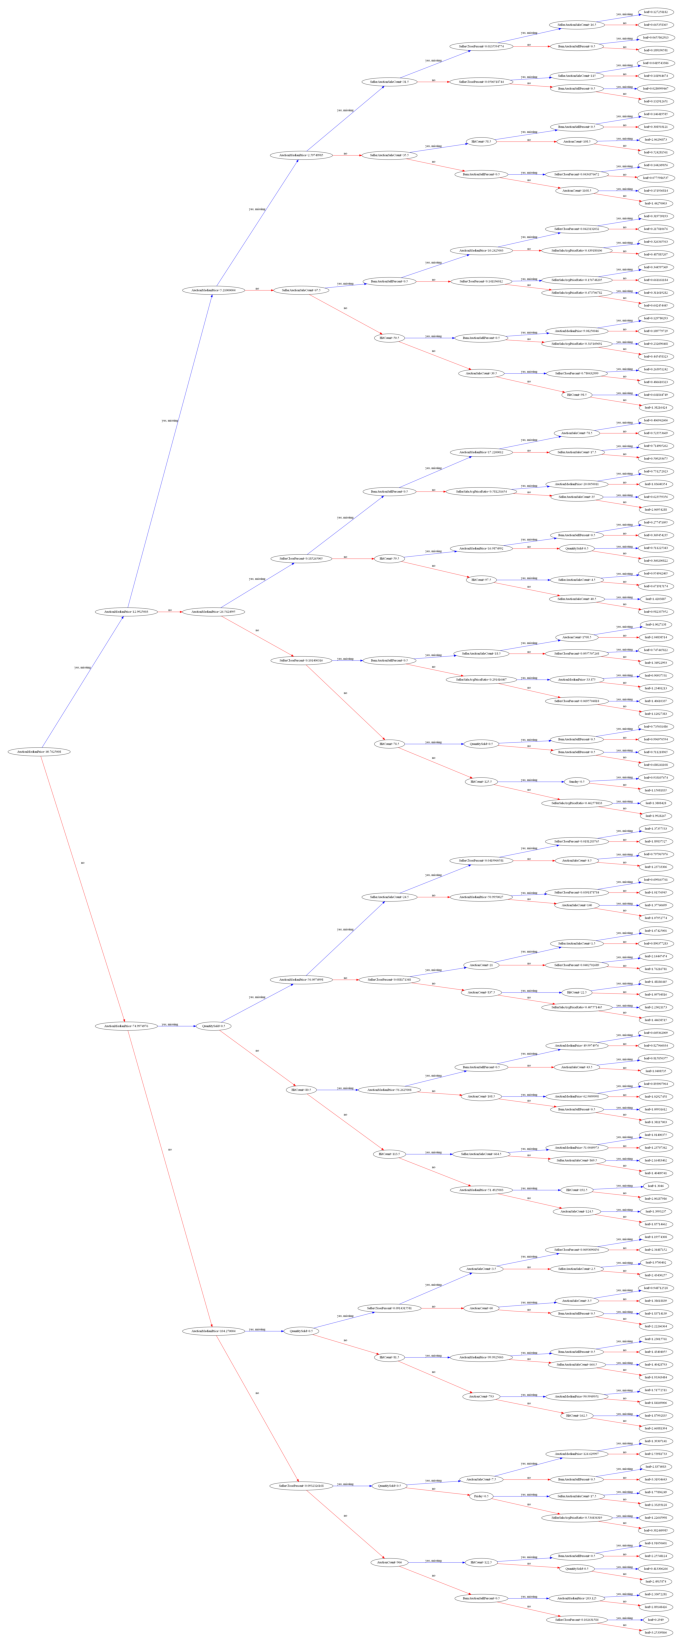

In [543]:
#view tree
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(model1, num_trees=0, rankdir='LR', ax = ax)

In [544]:
model2 = XGBRegressor(
    max_depth=7,
    n_estimators=1200,
    learning_rate = 0.015,
    seed=9)

In [545]:

model2.fit(
    X1, 
    y1, 
    eval_metric="rmse", 
    eval_set=[(X1, y1), (Xt, yt)], 
    verbose=True, 
    early_stopping_rounds = 20)

[0]	validation_0-rmse:52.12052	validation_1-rmse:46.53442
[1]	validation_0-rmse:51.38187	validation_1-rmse:45.87242
[2]	validation_0-rmse:50.65444	validation_1-rmse:45.21946
[3]	validation_0-rmse:49.93789	validation_1-rmse:44.57851
[4]	validation_0-rmse:49.23419	validation_1-rmse:43.94750
[5]	validation_0-rmse:48.54106	validation_1-rmse:43.32633
[6]	validation_0-rmse:47.85793	validation_1-rmse:42.71397
[7]	validation_0-rmse:47.18777	validation_1-rmse:42.11012
[8]	validation_0-rmse:46.52657	validation_1-rmse:41.51809
[9]	validation_0-rmse:45.87671	validation_1-rmse:40.93291
[10]	validation_0-rmse:45.23573	validation_1-rmse:40.35868
[11]	validation_0-rmse:44.60715	validation_1-rmse:39.79383
[12]	validation_0-rmse:43.98609	validation_1-rmse:39.23737
[13]	validation_0-rmse:43.37632	validation_1-rmse:38.69028
[14]	validation_0-rmse:42.77554	validation_1-rmse:38.15142
[15]	validation_0-rmse:42.18494	validation_1-rmse:37.62132
[16]	validation_0-rmse:41.60381	validation_1-rmse:37.09962
[17]	va

[139]	validation_0-rmse:12.51320	validation_1-rmse:11.18795
[140]	validation_0-rmse:12.46141	validation_1-rmse:11.14513
[141]	validation_0-rmse:12.41161	validation_1-rmse:11.10349
[142]	validation_0-rmse:12.36126	validation_1-rmse:11.06165
[143]	validation_0-rmse:12.31212	validation_1-rmse:11.02133
[144]	validation_0-rmse:12.26438	validation_1-rmse:10.97945
[145]	validation_0-rmse:12.21806	validation_1-rmse:10.94004
[146]	validation_0-rmse:12.17293	validation_1-rmse:10.90034
[147]	validation_0-rmse:12.13007	validation_1-rmse:10.86280
[148]	validation_0-rmse:12.08661	validation_1-rmse:10.82647
[149]	validation_0-rmse:12.04423	validation_1-rmse:10.79170
[150]	validation_0-rmse:12.00335	validation_1-rmse:10.75639
[151]	validation_0-rmse:11.96246	validation_1-rmse:10.72360
[152]	validation_0-rmse:11.92333	validation_1-rmse:10.68947
[153]	validation_0-rmse:11.88570	validation_1-rmse:10.65747
[154]	validation_0-rmse:11.84833	validation_1-rmse:10.62647
[155]	validation_0-rmse:11.81156	validat

[278]	validation_0-rmse:10.16537	validation_1-rmse:9.41940
[279]	validation_0-rmse:10.15998	validation_1-rmse:9.41745
[280]	validation_0-rmse:10.15581	validation_1-rmse:9.41538
[281]	validation_0-rmse:10.15094	validation_1-rmse:9.41436
[282]	validation_0-rmse:10.14567	validation_1-rmse:9.41163
[283]	validation_0-rmse:10.14030	validation_1-rmse:9.40948
[284]	validation_0-rmse:10.13545	validation_1-rmse:9.40835
[285]	validation_0-rmse:10.13135	validation_1-rmse:9.40667
[286]	validation_0-rmse:10.12640	validation_1-rmse:9.40509
[287]	validation_0-rmse:10.12159	validation_1-rmse:9.40264
[288]	validation_0-rmse:10.11678	validation_1-rmse:9.40113
[289]	validation_0-rmse:10.11206	validation_1-rmse:9.40031
[290]	validation_0-rmse:10.10769	validation_1-rmse:9.39870
[291]	validation_0-rmse:10.10309	validation_1-rmse:9.39703
[292]	validation_0-rmse:10.09772	validation_1-rmse:9.39452
[293]	validation_0-rmse:10.09344	validation_1-rmse:9.39253
[294]	validation_0-rmse:10.08862	validation_1-rmse:9.390

[419]	validation_0-rmse:9.65133	validation_1-rmse:9.33099
[420]	validation_0-rmse:9.64752	validation_1-rmse:9.32961
[421]	validation_0-rmse:9.64564	validation_1-rmse:9.32895
[422]	validation_0-rmse:9.64152	validation_1-rmse:9.32872
[423]	validation_0-rmse:9.64002	validation_1-rmse:9.32858
[424]	validation_0-rmse:9.63906	validation_1-rmse:9.32868
[425]	validation_0-rmse:9.63552	validation_1-rmse:9.32854
[426]	validation_0-rmse:9.63369	validation_1-rmse:9.32819
[427]	validation_0-rmse:9.63165	validation_1-rmse:9.32819
[428]	validation_0-rmse:9.62775	validation_1-rmse:9.32810
[429]	validation_0-rmse:9.62689	validation_1-rmse:9.32802
[430]	validation_0-rmse:9.62493	validation_1-rmse:9.32811
[431]	validation_0-rmse:9.62069	validation_1-rmse:9.32794
[432]	validation_0-rmse:9.61986	validation_1-rmse:9.32789
[433]	validation_0-rmse:9.61756	validation_1-rmse:9.32785
[434]	validation_0-rmse:9.61681	validation_1-rmse:9.32791
[435]	validation_0-rmse:9.61456	validation_1-rmse:9.32775
[436]	validati

[561]	validation_0-rmse:9.26705	validation_1-rmse:9.28593
[562]	validation_0-rmse:9.26577	validation_1-rmse:9.28556
[563]	validation_0-rmse:9.26314	validation_1-rmse:9.28518
[564]	validation_0-rmse:9.26122	validation_1-rmse:9.28451
[565]	validation_0-rmse:9.26024	validation_1-rmse:9.28463
[566]	validation_0-rmse:9.25769	validation_1-rmse:9.28474
[567]	validation_0-rmse:9.25525	validation_1-rmse:9.28509
[568]	validation_0-rmse:9.25419	validation_1-rmse:9.28430
[569]	validation_0-rmse:9.25007	validation_1-rmse:9.28420
[570]	validation_0-rmse:9.24938	validation_1-rmse:9.28429
[571]	validation_0-rmse:9.24723	validation_1-rmse:9.28418
[572]	validation_0-rmse:9.24474	validation_1-rmse:9.28388
[573]	validation_0-rmse:9.24235	validation_1-rmse:9.28377
[574]	validation_0-rmse:9.24134	validation_1-rmse:9.28384
[575]	validation_0-rmse:9.23924	validation_1-rmse:9.28366
[576]	validation_0-rmse:9.23558	validation_1-rmse:9.28329
[577]	validation_0-rmse:9.23456	validation_1-rmse:9.28259
[578]	validati

[703]	validation_0-rmse:8.96743	validation_1-rmse:9.25806
[704]	validation_0-rmse:8.96580	validation_1-rmse:9.25780
[705]	validation_0-rmse:8.96444	validation_1-rmse:9.25793
[706]	validation_0-rmse:8.96231	validation_1-rmse:9.25709
[707]	validation_0-rmse:8.95928	validation_1-rmse:9.25513
[708]	validation_0-rmse:8.95705	validation_1-rmse:9.25476
[709]	validation_0-rmse:8.95496	validation_1-rmse:9.25397
[710]	validation_0-rmse:8.95349	validation_1-rmse:9.25416
[711]	validation_0-rmse:8.95208	validation_1-rmse:9.25465
[712]	validation_0-rmse:8.94986	validation_1-rmse:9.25471
[713]	validation_0-rmse:8.94776	validation_1-rmse:9.25340
[714]	validation_0-rmse:8.94481	validation_1-rmse:9.25148
[715]	validation_0-rmse:8.94391	validation_1-rmse:9.25183
[716]	validation_0-rmse:8.94092	validation_1-rmse:9.25114
[717]	validation_0-rmse:8.93889	validation_1-rmse:9.25039
[718]	validation_0-rmse:8.93687	validation_1-rmse:9.24978
[719]	validation_0-rmse:8.93590	validation_1-rmse:9.25009
[720]	validati

[845]	validation_0-rmse:8.73869	validation_1-rmse:9.22412
[846]	validation_0-rmse:8.73760	validation_1-rmse:9.22422
[847]	validation_0-rmse:8.73469	validation_1-rmse:9.22419
[848]	validation_0-rmse:8.73353	validation_1-rmse:9.22412
[849]	validation_0-rmse:8.73230	validation_1-rmse:9.22443
[850]	validation_0-rmse:8.73151	validation_1-rmse:9.22487
[851]	validation_0-rmse:8.73055	validation_1-rmse:9.22459
[852]	validation_0-rmse:8.72979	validation_1-rmse:9.22454
[853]	validation_0-rmse:8.72818	validation_1-rmse:9.22384
[854]	validation_0-rmse:8.72620	validation_1-rmse:9.22310
[855]	validation_0-rmse:8.72360	validation_1-rmse:9.22327
[856]	validation_0-rmse:8.72161	validation_1-rmse:9.22244
[857]	validation_0-rmse:8.72028	validation_1-rmse:9.22270
[858]	validation_0-rmse:8.71949	validation_1-rmse:9.22266
[859]	validation_0-rmse:8.71836	validation_1-rmse:9.22242
[860]	validation_0-rmse:8.71677	validation_1-rmse:9.22216
[861]	validation_0-rmse:8.71610	validation_1-rmse:9.22223
[862]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.015, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=9, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=9, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [546]:
score_best = model2.score(X1, y1)
score_best

0.9624422868881015

In [547]:
model2.best_ntree_limit

917

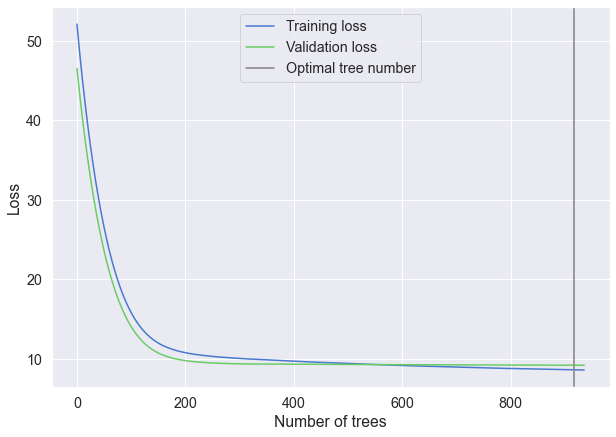

In [548]:
results = model2.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(model2.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

<AxesSubplot:>

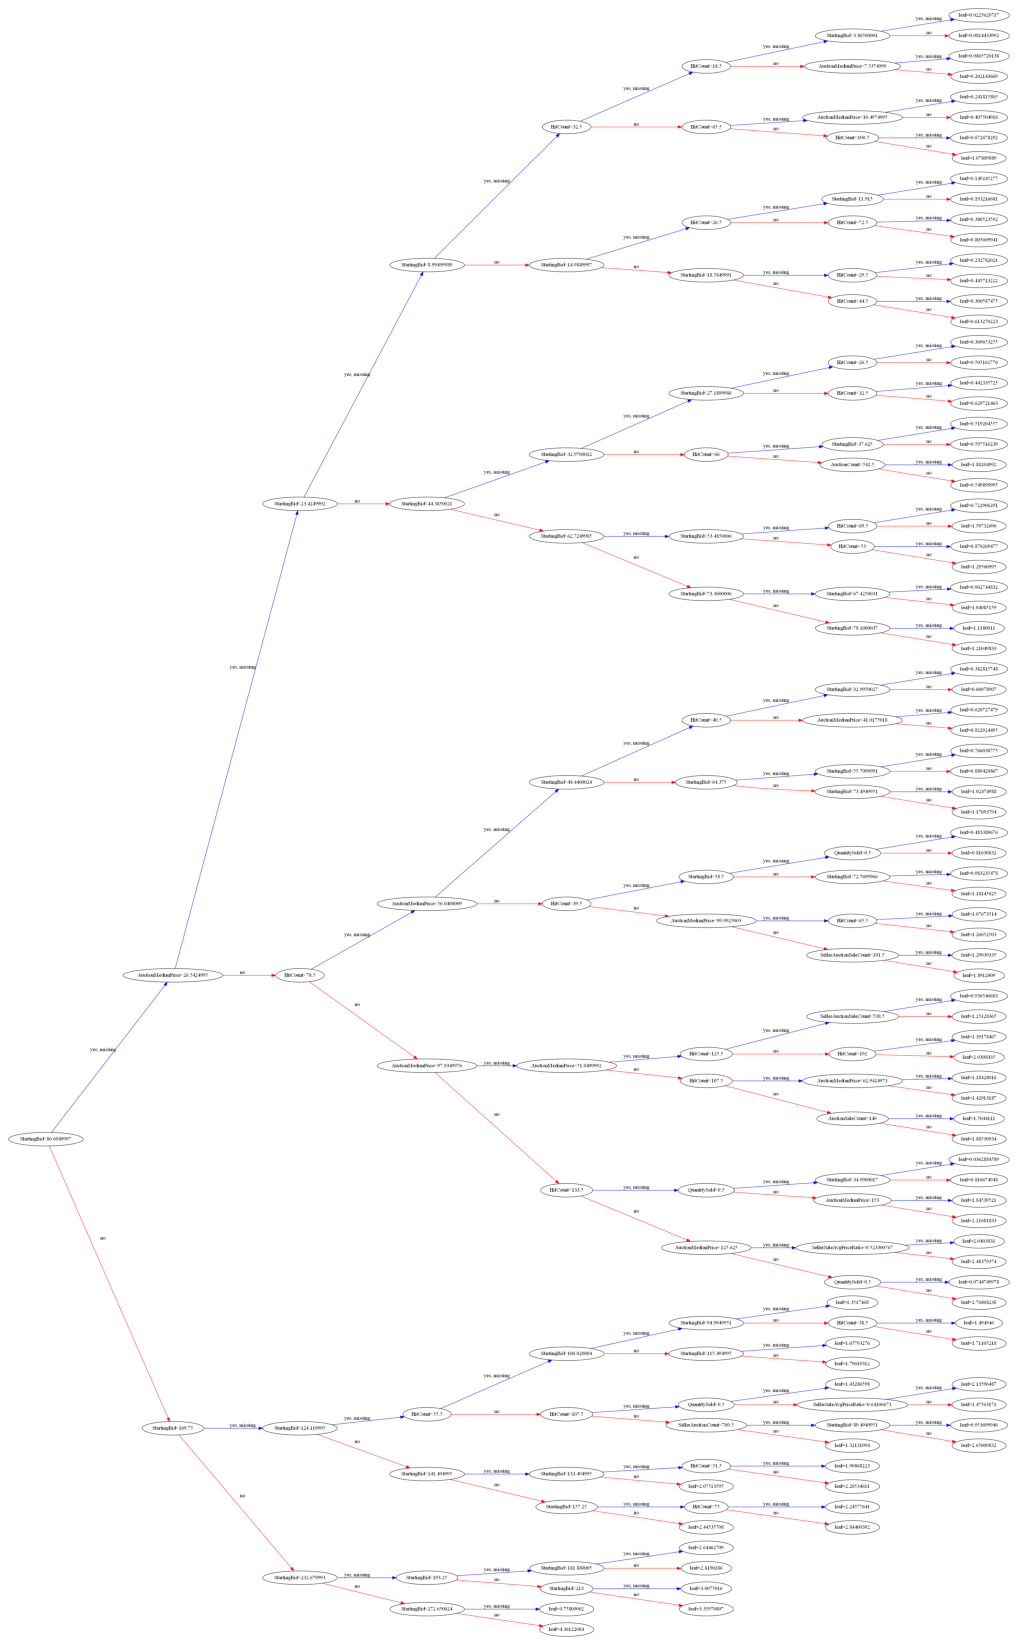

In [549]:
#view tree
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(model2, num_trees=0, rankdir='LR', ax = ax)

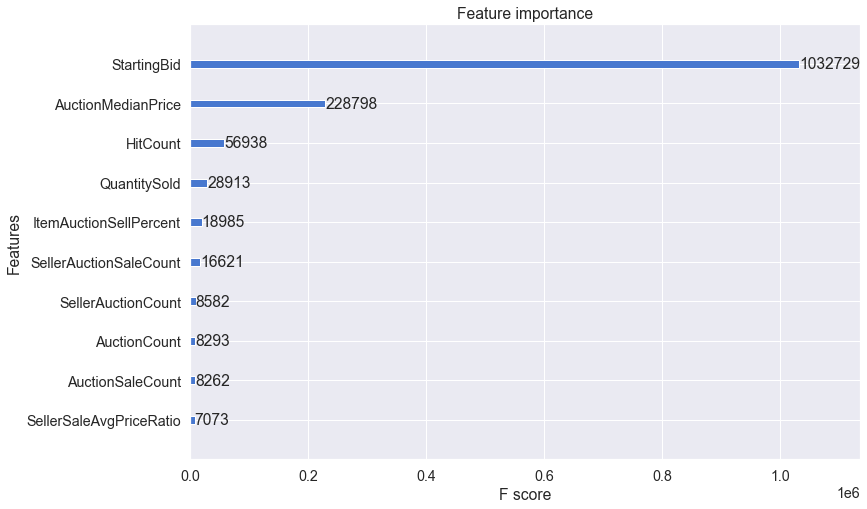

In [567]:
#plot importance - gain
booster = model.get_booster()
importance = booster.get_score(importance_type="gain")

for key in importance.keys():
    importance[key] = int(round(importance[key],0))

ax = plot_importance(importance, max_num_features=10, importance_type='gain', show_values=True)

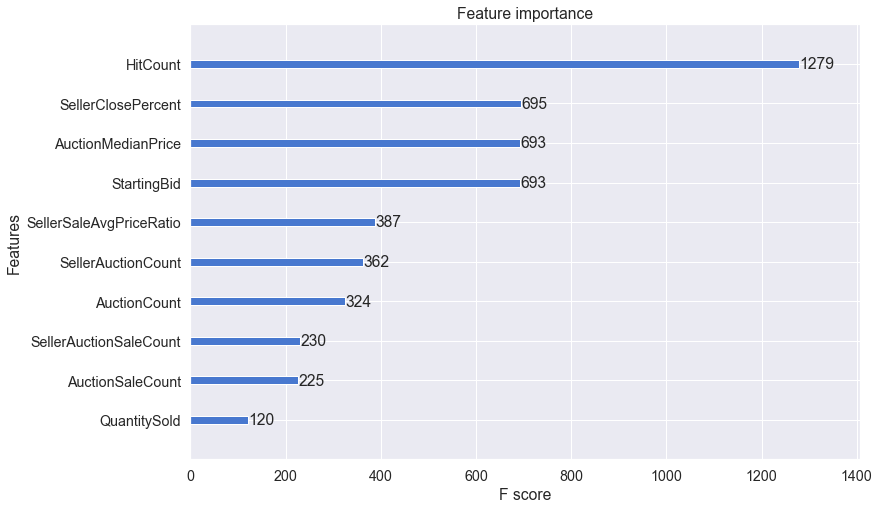

In [570]:
#plot importance - weight
booster = model.get_booster()
importance = booster.get_score(importance_type="weight")

for key in importance.keys():
    importance[key] = int(round(importance[key],0))

ax = plot_importance(importance, max_num_features=10, importance_type='weight', show_values=True)

In [259]:
import seaborn as sns
sns.set_theme(style="whitegrid")

In [573]:
#another way to view the importance plot
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data = data.reset_index()


<AxesSubplot:xlabel='score', ylabel='index'>

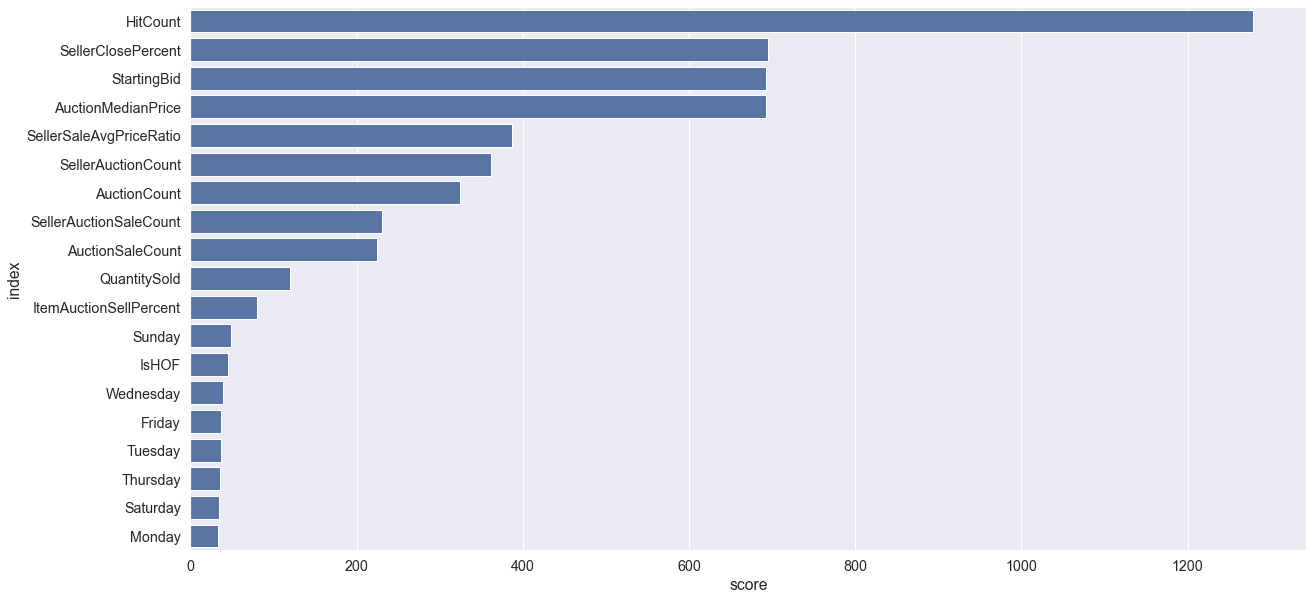

In [574]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="score", y="index", data=data,
            label="Total", color="b")

In [575]:
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data = data.reset_index()

<AxesSubplot:xlabel='score', ylabel='index'>

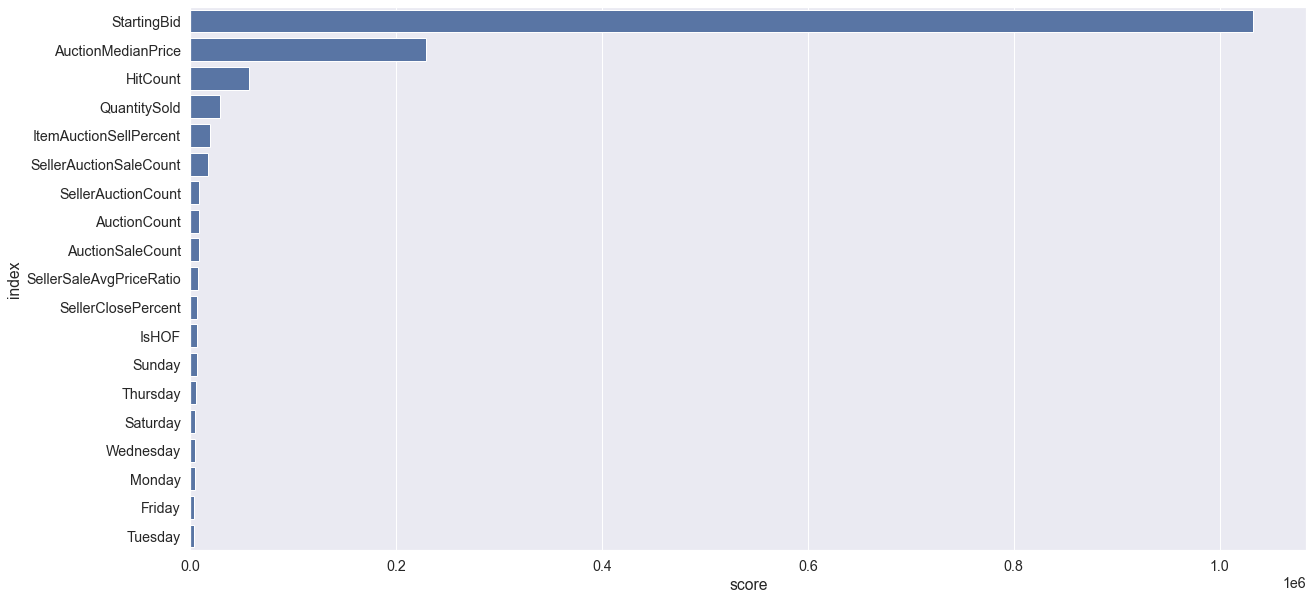

In [576]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="score", y="index", data=data,
            label="Total", color="b")

In [577]:
from sklearn.inspection import permutation_importance

In [588]:
perm_importance = permutation_importance(model, X1, y1)


In [589]:
sorted_idx

array([17, 12, 13, 18, 14, 16, 15,  6,  1,  5,  8,  7,  9, 10,  4,  0,  3,
       11,  2], dtype=int64)

Text(0.5, 0, 'Permutation Importance')

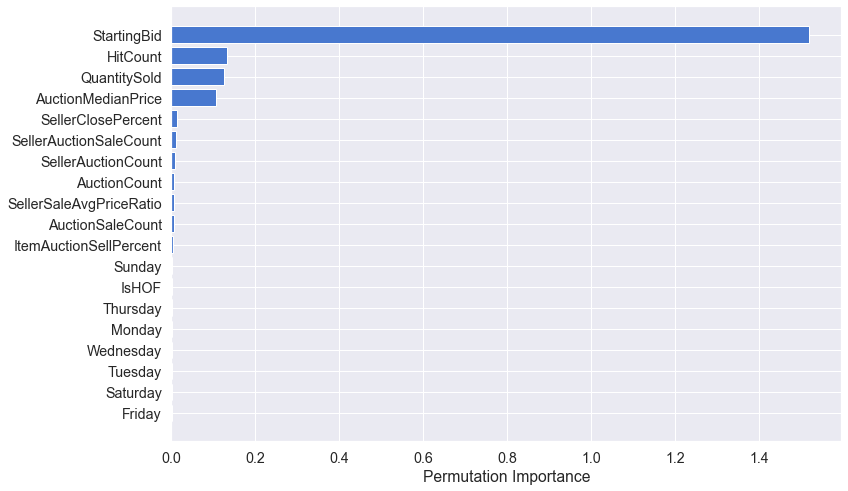

In [590]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(Xt.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [591]:
sorted_idx = model.feature_importances_.argsort()
sorted_idx

array([17, 12, 13, 18, 14, 16, 15,  6,  1,  5,  8,  7,  9, 10,  4,  0,  3,
       11,  2], dtype=int64)

Text(0.5, 0, 'Xgboost Feature Importance')

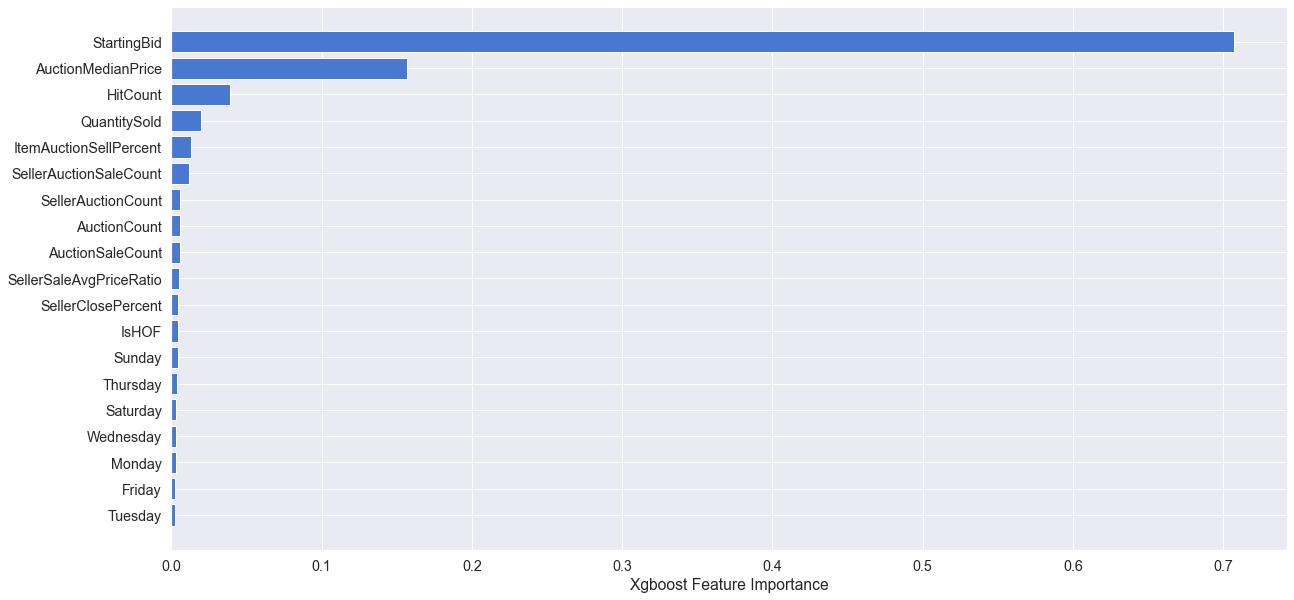

In [592]:
plt.figure(figsize=(20,10))
plt.barh(X1.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")


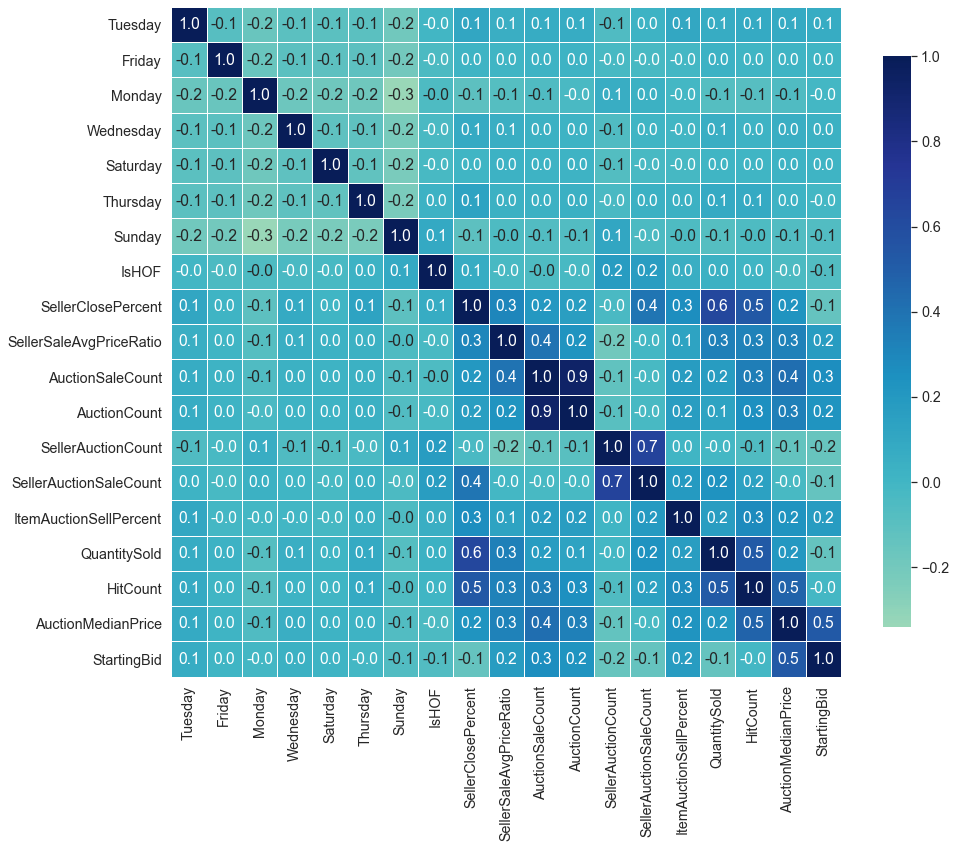

In [604]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.1f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    #plt.xticks(rotation=45)
    plt.show();
    

correlation_heatmap(Xt[train.loc[:, ~train.columns.isin(['Price', 'EbayID', 'SellerName'])].columns[sorted_idx]])

In [605]:
import shap

In [606]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xt)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


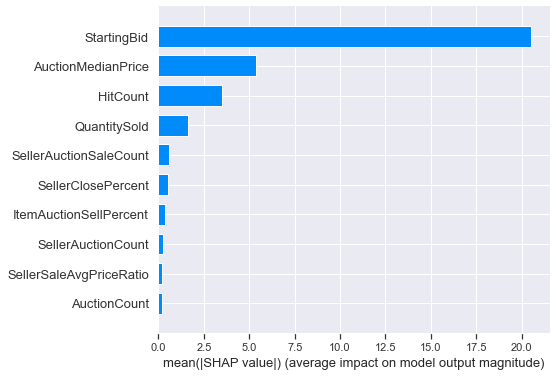

In [609]:
shap.summary_plot(shap_values, Xt, plot_type="bar", max_display = 10)

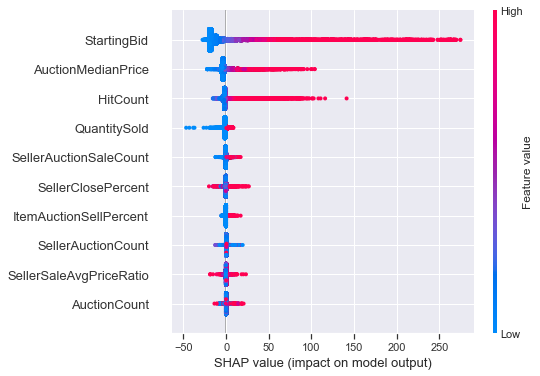

In [611]:
shap.summary_plot(shap_values, Xt, max_display = 10)

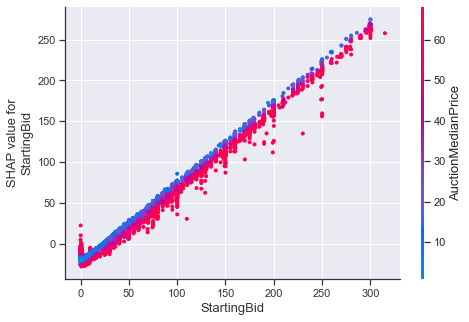

In [615]:

shap.dependence_plot("StartingBid", shap_values, Xt)

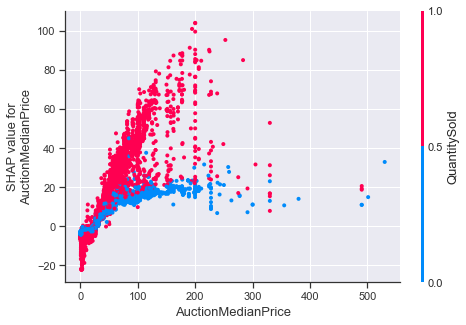

In [613]:
shap.dependence_plot("AuctionMedianPrice", shap_values, Xt)

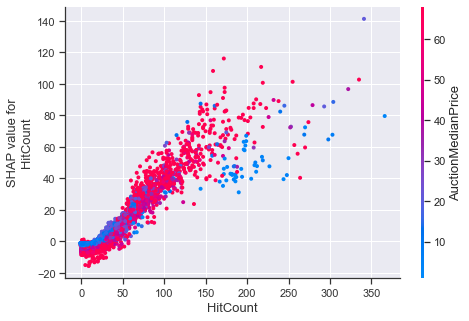

In [614]:
shap.dependence_plot("HitCount", shap_values, Xt)

## Scikit-learn Grid Search

In [623]:
from sklearn.model_selection import GridSearchCV
import time

In [637]:
#set up model
regressor = xg.XGBRegressor(eval_metric='rmse', base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                 colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
                                 gamma=0, gpu_id=-1, importance_type=None,
                                 interaction_constraints='', max_delta_step=0,
                                 min_child_weight=1, 
                                 monotone_constraints='()', n_jobs=8,
                                 num_parallel_tree=1, predictor='auto', random_state=9, reg_alpha=0,
                                 reg_lambda=1, scale_pos_weight=1, seed=9, subsample=1,
                                 tree_method='exact', validate_parameters=1, verbosity=None)


In [638]:
%%time
#run grid search with following parameters to find the best parameter values
param_grid1 = {"max_depth":    [5, 7, 10],
              "n_estimators": [100, 300, 700, 1200],
              "learning_rate": [0.3, 0.1, 0.015]}
                #'colsample_bytree': [0.3, 0.7]}

search1 = GridSearchCV(regressor, param_grid1, cv=5).fit(X1, y1)



Wall time: 3h 44min 37s


In [639]:
#what are the best parameters?
search1.best_params_

{'learning_rate': 0.015, 'max_depth': 7, 'n_estimators': 700}

In [640]:
#what is the best score of the search?
search1.best_score_

0.9405513575619254

In [625]:
%%time
#run grid search with following parameters to find the best parameter values
param_grid = {"max_depth":    [5, 7, 10],
              "n_estimators": [100, 300, 700, 1200],
              "learning_rate": [0.3, 0.1, 0.015]}
                #'colsample_bytree': [0.3, 0.7]}

search = GridSearchCV(regressor, param_grid, cv=5).fit(X1, y1)



Wall time: 3h 47min 38s


In [626]:
#what are the best parameters?
search.best_params_

{'learning_rate': 0.015, 'max_depth': 7, 'n_estimators': 700}

In [627]:
search

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', gamma=None, gpu_id=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                           

In [628]:
#what is the best score of the search?
search.best_score_

0.9405513575619254

In [632]:
#save final results
final_search_results = search.cv_results_
final_search_results

{'mean_fit_time': array([  8.99335079,  25.7024332 ,  51.82266335,  90.07989202,
         12.26203794,  35.39990473,  78.21581278, 138.37058744,
         17.78615894,  55.54234042, 147.16719956, 228.10264797,
          7.90241456,  23.92503872,  53.90959611,  88.3814178 ,
         11.17003708,  33.29667015,  75.94421554, 132.08402548,
         18.17448955,  52.45089192, 127.99145088, 246.39154825,
          9.76999097,  30.88970795,  65.85927868, 105.51218352,
         12.13789668,  36.43543653,  80.48276563, 134.88250933,
         19.1045105 ,  57.86506963, 128.86594005, 250.95246549]),
 'std_fit_time': array([ 1.59484189,  0.73884184,  2.65928769,  4.69665486,  0.94862287,
         2.35156367,  1.91089581,  4.73507385,  0.31588285,  3.2899493 ,
         8.05498956,  4.39161334,  0.22266573,  1.41742865,  0.61147074,
         0.67043248,  0.14626973,  0.79242405,  0.460021  ,  2.00856323,
         0.13621085,  0.23387037,  6.08622182,  9.2636752 ,  1.85957242,
         5.42482756,  6.

In [633]:
#save final search
final_search = search
final_search

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', gamma=None, gpu_id=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                           

In [ ]:
model3 = XGBRegressor(
    max_depth=7,
    n_estimators=1200,
    learning_rate = 0.015,
    seed=9)